# DL Competition 4 Report
Team_123 組員:
* 110065512 鄭程哲
* 110062528 彭嘉洛
* 110062401 李浩榮
* 109062702 楊晴雯

在這次的報告中，我們會先講述各個部分我們做了甚麼嘗試以及讓accuracy提升的幾個milestone，最後再總結我們最終model使用的方法。

||Cifar-10|Imagenet|
|:-----:|:-----:|:-----:|
|Public|0.69460 (19th)|0.96 (7th)|
|Private|0.68760 (15th)|0.90 (13rd)|

# Dataset
在資料前處理的部分我們做了去噪、加噪、資料擴增三個方向

## Denoising
我們覺得`NTGA`就是對原始圖片加了一些噪點，使得model沒辦法好好地進行訓練，因此透過一些不同的去噪方式，說不定能夠讓圖片去噪，盡可能地恢復成比較接近原始的樣子(或是產生更泛化的圖片)，在Denoising的部分我們分別嘗試了三種不同的方法

* <B>Denoising Autoencoder</B>: 提到去噪，autoencoder是我們最先想到的方式，透過NN將有噪點的圖片還原成沒有噪點的圖片，下圖一是將加了noise的圖片餵進訓練好的model所產生的圖片，圖二則是對原始的`x_train`、`x_val`丟進autoencoder後產生的圖片結果。可以從圖二看出，經過denoising autoencoder後的圖片比較模糊，可能可以讓model去除一些`NTGA`的干擾，不過在後來的實驗中，autoencoder並沒有明顯的提升model表現。 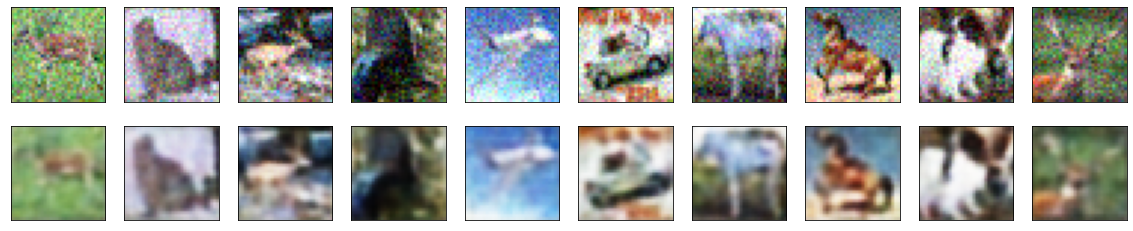
<center>圖一、</center>

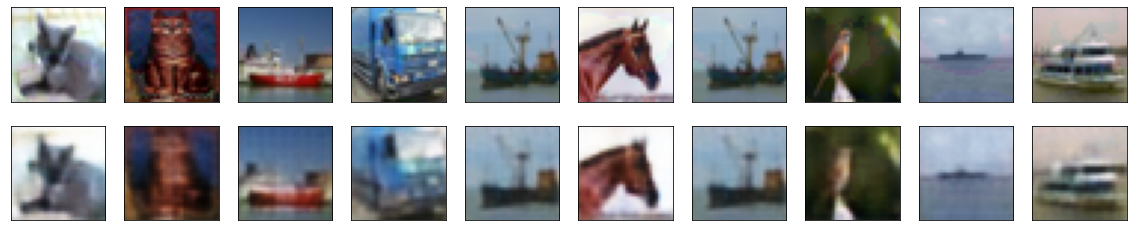

<center>圖二、</center>


* <B>Filters</B>: 第二個嘗試的方法是使用不同的Filter將圖片先過濾一次，我們分別嘗試了`Wiener filter`、`Gaussian filter`，使用filter後的圖片會跟autoencoder的結果類似，圖片都會變得稍微模糊一些，可以視為更泛化一點。但這兩種方法經過我們的實驗後，發現效果都沒有很明顯。

* <B>Grayscale</B>: 我們認為將圖片的顏色視為一種干擾而去除，可能可以幫助model更專注於pattern的識別，所以我們試著將所有資料集(包含`x_train`、`x_val`、`x_test`)做灰階轉換，透過實驗發現，在同樣model設定下，灰階圖片的表現比RGB圖片來的好很多，所以這個方法也有使用在最終model之中。

* <B>Sobel Edge Detection</B>: 因為原始圖片被`NTGA`擾動過，所以我們嘗試將圖片直接轉換成完全不同形式的圖片，說不定可以重新讓model學習正確的辨別。在Cifar-10上效果沒有很好，不過在Imagenet上的表現很好(public score: 0.96)，我們猜測其中一個原因可能是因為Cifar-10的圖片尺寸太小(32x32)，如圖三所示，轉後過後的圖片人眼都很難去分辨了，edge資訊可能不足以讓model學出representing features；但Imagenet圖片相對大很多(224x224)，加上只有兩個class要分類，所以在Imagenet上有不錯的表現。

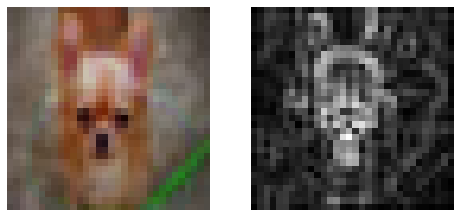
<br>
圖三、Sobel轉換對照圖

## Add Noise
在training data上加噪點是很常見的資料前處理方式，我們的想法是既然原本圖片被破壞，那是否可以透過增加一些noise使model有更好的表現及泛化能力。<br>
noise我們測試了多種方式，如下所示：

1. 在原始圖片上加入`gaussian noise`，`# of data = 1x`
2. 在原始圖片上加入`gaussian noise`，`speckle noise`，`# of data = 1x`
3. 在原始圖片上加入`gaussian noise`，`speckle noise`，`salt&pepper noise`，`poisson noise`，`# of data = 1x`
4. 原始圖片+`gaussian noise`圖片 `1:1`，`# of data = 2x`
5. 原始圖片+`speckle noise`圖片 `1:1`，`# of data = 2x`
6. 原始圖片+`gaussian noise`圖片+`speckle noise`圖片 `1:1:1`，`# of data = 3x`

以實驗結果來看，1. 4. 這兩種方法的表現最好，最終model我們使用4. 。

## Data Augmentation
這部分我們使用常見的幾個方法擴充dataset，包含`Horizontal flip`、`Vertical flip`、`Random brightness`等，因為方法和以往的Lab與Competition都差不多，所以就不多贅述。

# Model Design & Select
在model選擇上，我們嘗試了很多種模型，包含: `VGG19`，`Densenet121`，`EfficientNet`，`Resnet50`，`Xception`，普遍來說，最後兩個model的表現最好，最終model是使用<b>`Xception`</b>，但在不同的設定下，`Resnet50`有時也會有比較好的表現，所以我們認為model可能不會是影響performance最關鍵的原因。<br><br>
另外我們也嘗試在backbone model後加上一些convolution layer和dense layer，並將backbone freeze住不做訓練，但效果也不顯著，所以後來就把這項變因拔除。<br><br>
最後，我們在backbone model前面加上augmentation layer，讓所有的input image做隨機的水平翻轉、旋轉、縮放，這部分的效果不錯，有讓表現提升一些，但因為有點和前處理的data augmentation衝突，所以最終的模型我們只使用這個augmentation layer。

# Final Model
## Cifar-10
### Dataset
* 原始圖片+`gaussian noise (mean=0, var=0.1)`圖片 `1:1`，`# of data = 2x`
* 再將所有圖片轉換為灰階

### Model
* Augmentation layer: `horizontal flip`, `random rotate`, `random zooming`
* Backbone: `Xception`

## Imagenet
### Dataset
* 先將原始資料轉為灰階
* Sobel Edge Detection
* Data augmentation: `Horizontal flip`、`Vertical flip`、`Random brightness`，`# of data = 4x`

### Model
* Backbone: `Resnet50`